# UFC Winner Predictor

### Importing Libraries 

In [4]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import os, datetime
%reload_ext tensorboard

### Loading Data

In [2]:
data = pd.read_csv('./data/ufc_data.csv')
data = data.sample(frac=1)
data.head()

,Winner,title_bout,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,...,weight_class_Women's Strawweight,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Southpaw,R_Stance_Switch
16,Blue,False,3,1.0,0.0,0.0,26.000000,22.200000,30.200000,24.800000,...,0,0,1,0,0,0,0,1,0,0
2737,Red,False,3,0.0,3.0,0.0,1.400000,0.800000,2.000000,1.000000,...,0,0,1,0,0,0,0,1,0,0
2006,Red,False,3,3.0,0.0,0.0,2.400000,2.200000,9.200000,6.500000,...,0,0,1,0,0,0,0,1,0,0
1953,Red,False,3,0.0,1.0,0.0,11.833333,7.833333,1.500000,0.666667,...,0,0,1,0,0,0,0,1,0,0
630,Red,False,5,1.0,0.0,0.0,4.444444,3.944444,4.388889,3.833333,...,0,0,0,0,1,0,0,0,1,0


### Data Preprocesing

In [3]:
data['Winner'] = data['Winner'].map(lambda x: 1 if x == 'Red' else 0)
data['title_bout'] = data['title_bout'].map(lambda x: 1 if x == 'True' else 0)

### Data Visualization

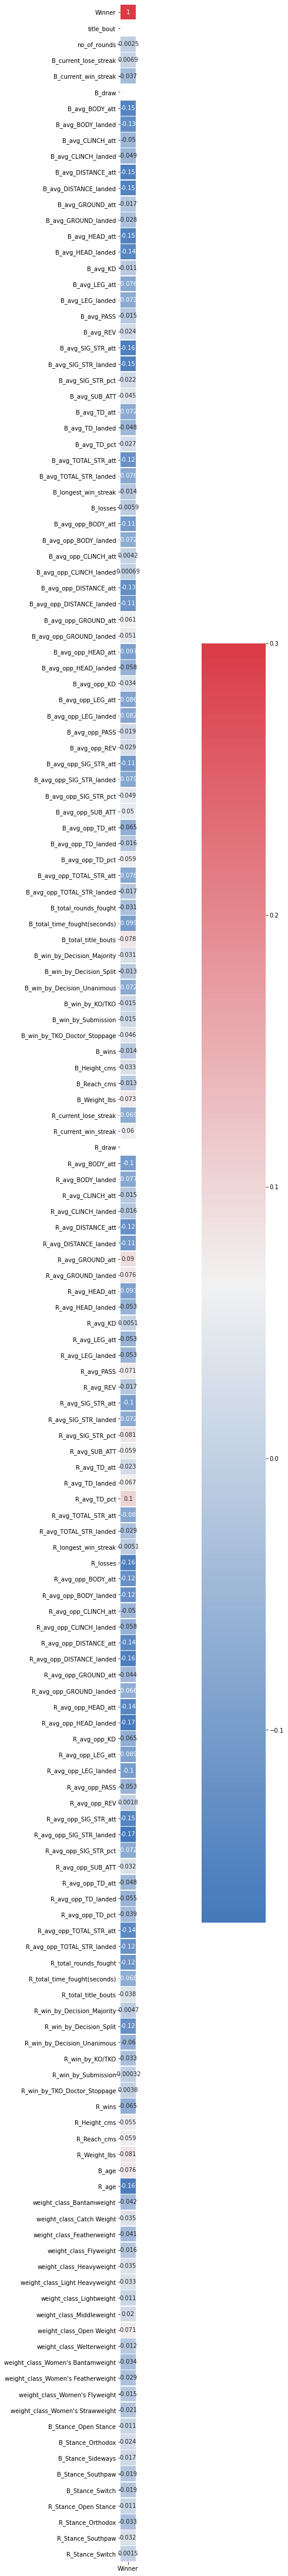

In [8]:
corr = data.corr()
cmap = sns.diverging_palette(250, 10, as_cmap=True)
plt.figure(figsize=(40, 80))
sns.heatmap(corr[['Winner']], cmap=cmap, vmax=.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=True);

### Train Test Split

In [32]:
train_size = int(0.8*len(data))
features = data.drop(columns=['Winner'])
targets = data['Winner']
X_train, X_test = features.values[:train_size, :], features.values[train_size:, :]
y_train, y_test = targets.values[:train_size], targets.values[train_size:]

### Building the ANN Model

In [33]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [34]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3)
])

red = len(y_train[y_train>0])
blue = len(y_train) - red
total = len(y_train)
weight_for_red = total / (2 * red) 
weight_for_blue = total / (2 * blue)
class_weight = {0: weight_for_blue, 1: weight_for_red}
print(class_weight)

{0: 1.4628309572301426, 1: 0.75965097831835}


In [35]:
adam_optimizer = tf.keras.optimizers.Adam()
model.compile(
    optimizer=adam_optimizer,
    loss='binary_crossentropy',
    metrics=[
#       tf.keras.metrics.TruePositives(name='tp'),
#       tf.keras.metrics.FalsePositives(name='fp'),
#       tf.keras.metrics.TrueNegatives(name='tn'),
#       tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
#       tf.keras.metrics.Precision(name='precision'),
#       tf.keras.metrics.Recall(name='recall'),
#       tf.keras.metrics.AUC(name='auc'),
    ]
)


In [36]:
save_best_callback = tf.keras.callbacks.ModelCheckpoint(
    '/content/model-{epoch:02d}-{val_accuracy:.2f}.hdf5', 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True, 
    save_weights_only=False,
    save_frequency=1)

logdir = os.path.join('tflogs2', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, 
                                                      histogram_freq=1,
                                                      profile_batch=0)

%tensorboard --logdir tflogs2

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
model.fit(X_train_scaled, 
          y_train,
          class_weight=class_weight,
          batch_size=64,
          validation_split=0.1,
          callbacks=[save_best_callback, tensorboard_callback],
          epochs=20)

Reusing TensorBoard on port 6006 (pid 13380), started 0:06:56 ago. (Use '!kill 13380' to kill it.)

Epoch 1/20
41/41 [==============================] - 1s 18ms/step - loss: 5.2522 - accuracy: 0.4917 - val_loss: 5.2402 - val_accuracy: 0.5220

Epoch 00001: val_accuracy improved from -inf to 0.52199, saving model to /content\model-01-0.52.hdf5
Epoch 2/20
41/41 [==============================] - 0s 4ms/step - loss: 4.9343 - accuracy: 0.5571 - val_loss: 4.8032 - val_accuracy: 0.5637

Epoch 00002: val_accuracy improved from 0.52199 to 0.56366, saving model to /content\model-02-0.56.hdf5
Epoch 3/20
41/41 [==============================] - 0s 3ms/step - loss: 5.2919 - accuracy: 0.5483 - val_loss: 5.4103 - val_accuracy: 0.5567

Epoch 00003: val_accuracy did not improve from 0.56366
Epoch 4/20
41/41 [==============================] - 0s 3ms/step - loss: 5.2197 - accuracy: 0.5614 - val_loss: 4.9664 - val_accuracy: 0.5787

Epoch 00004: val_accuracy improved from 0.56366 to 0.57870, saving model to /content\model-04-0.58.hdf5
Epoch 5/20
41/41 [==============================] - 0s 4ms/step - loss:

In [38]:
X_test_scaled = scaler.transform(X_test)
model.evaluate(X_test_scaled, y_test)

23/23 [==============================] - 0s 955us/step - loss: 4.9126 - accuracy: 0.5971


[4.912561893463135, 0.5971256494522095]